<a href="https://colab.research.google.com/github/dougfletcher10/W207/blob/master/Week_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayes Theory

<img src="https://pcdn.piiojs.com/i/kqctmw/vw,222,vh,0,r,1,pr,2,wp,1/https%3A%2F%2Fmonkeylearn.com%2Fblog%2Fwp-content%2Fql-cache%2Fquicklatex.com-6f656ab975a4dc6d1bfd2af6bc601af3_l3.png">

## Build and text a Naive Bayes classifier
We will again use the iris data. In case you don't feel familiar with the iris varieties yet, here are some pictures. The petals are smaller and stick out above the larger, flatter sepals. In many flowers, the sepal is a greenish support below the petals, but the iris sepals are designed specifically as landing pads for bumblebees, and the bright yellow coloring on the sepal directs the bees down into the tight space where pollination happens.

<img src="https://www.pngkey.com/png/full/82-826789_iris-iris-sepal-and-petal.png">


In [0]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.naive_bayes import BernoulliNB
import pandas as pd

In [0]:
# Load the data, which is included in sklearn.
iris = load_iris()
print ('Iris target names:', iris.target_names)
print ('Iris feature names:', iris.feature_names)
X, Y = iris.data, iris.target

# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

# Split into train and test.
train_data, train_labels = X[:100], Y[:100]
test_data, test_labels = X[100:], Y[100:]


Iris target names: ['setosa' 'versicolor' 'virginica']
Iris feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [0]:
len(X), len(train_data), len(test_data)

(150, 100, 50)

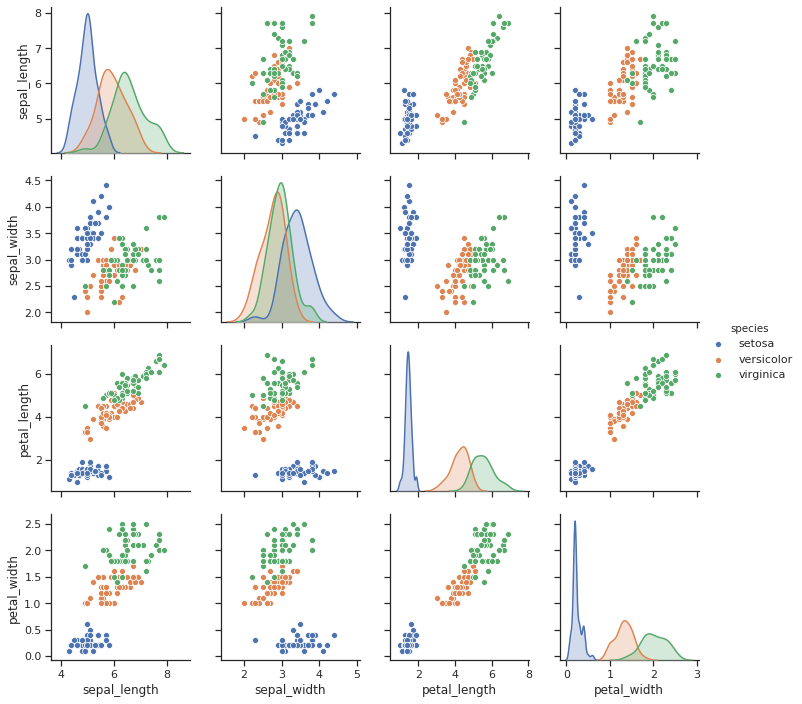

In [0]:
# we're actually loading the data set twice here 
# ignore this cell, other than the visualizaiton 
# seaborn has the data structured nicely for their viz
# so the labels in the legend display correctly
import seaborn as sns; sns.set(style="ticks", color_codes=True)
iris_sns = sns.load_dataset("iris")
g = sns.pairplot(iris_sns, hue="species")

## Feature engineering
To make things simple, let's binarize these feature values. That is, we'll treat each measurement as either "short" or "long". I'm just going to choose a threshold for each feature.

In [0]:
# Define a function that applies a threshold to turn real valued iris features into 0/1 features.
# 0 will mean "short" and 1 will mean "long".
def binarize_iris(data, thresholds=[6.0, 3.0, 2.5, 1.0]):
    # Initialize a new feature array with the same shape as the original data.
    binarized_data = np.zeros(data.shape)

    # Apply a threshold  to each feature.
    for feature in range(data.shape[1]):
        binarized_data[:,feature] = data[:,feature] > thresholds[feature]
    return binarized_data

# Create new binarized training and test data
binarized_train_data = binarize_iris(train_data)
binarized_test_data = binarize_iris(test_data)

# Remember
#       target index     0          1            2
# Iris target names: ['setosa' 'versicolor' 'virginica']

#      feature index            0                  1                     2                   3
# Iris feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

In [0]:
len(binarized_train_data), len(binarized_test_data)

(100, 50)

In [0]:
binarized_train_data[:5]

#      feature index            0                  1                     2                   3
# Iris feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

array([[0., 0., 1., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 1., 1.],
       [0., 1., 0., 0.]])

Recall that Naive Bayes assumes conditional independence of features. With $Y$ the set of labels and $X$ the set of features ($y$ is a specific label and $x$ is a specific feature), Naive Bayes gives the probability of a label $y$ given input features $X$ as:

$ \displaystyle P(y|X) \approx 
  \frac { P(y) \prod_{x \in X} P(x|y) }
        { \sum_{y \in Y} P(y) \prod_{x \in X} P(x|y) }
$

Let's estimate some of these probabilities using maximum likelihood, which is just a matter of counting and normalizing. We'll start with the prior probability of the label $P(y)$.

In [0]:
# Initialize counters for all labels to zero.
label_counts = [0 for i in iris.target_names]

# Iterate over labels in the training data and update counts.
for label in train_labels:
    label_counts[label] += 1

# Normalize counts to get a probability distribution.
total = sum(label_counts)

label_probs = [1.0 * count / total for count in label_counts]
for (prob, name) in zip(label_probs, iris.target_names):
    print ('%15s : %.2f' %(name, prob))

         setosa : 0.31
     versicolor : 0.33
      virginica : 0.36


Next, let's estimate $P(X|Y)$, that is, the probability of each feature given each label. Remember that we can get the conditional probability from the joint distribution:

$\displaystyle P(X|Y) = \frac{ P(X,Y) } { P(Y) } \approx \frac{ \textrm{Count}(X,Y) } { \textrm{Count}(Y) }$

Let's think carefully about the size of the count matrix we need to collect. There are 3 labels $y_1$, $y_2$, and $y_3$ and 4 features $x_0$, $x_1$, $x_2$, and $x_3$. Each feature has 2 possible values, 0 or 1. So there are actually $4 \times 2 \times 3=24$ probabilities we need to estimate:


$P(x_0=0, Y=y_0)$

$P(x_0=1, Y=y_0)$

$P(x_1=0, Y=y_0)$

$P(x_1=1, Y=y_0)$

...

However, we already estimated (above) the probability of each label. And, we know that each feature value is either 0 (short) or 1 (long. So, for example,


$P(x_{sepal\_len}=short, Y=\textrm{setosa}) + P(x_{sepal\_len}=long, Y=\textrm{setosa}) $

$= P(Y=\textrm{setosa}) $

$\approx 0.31$. 

As a result, we can just estimate probabilities for one of the feature values, say, $x_{sepal\_len} = short$. This requires a $4 \times 3$ matrix.

In [0]:
# Initialize a matrix for joint counts of feature=0 and label.
feature0_and_label_counts = np.zeros([len(iris.feature_names), len(iris.target_names)])

# Just to check our work, let's also keep track of joint counts of feature=1 and label.
feature1_and_label_counts = np.zeros([len(iris.feature_names), len(iris.target_names)])

# for each training example
for i in range(binarized_train_data.shape[0]):
    
    # get what kind of iris it actually is (the label)
    # this will be a number between 0 and 2
    #       target index     0          1            2
    # Iris target names: ['setosa' 'versicolor' 'virginica']
    label = train_labels[i] 
    
    # get a vector of feature values
    # this will be a list of four values (one for each feature)
    # that are either 0 (short) or 1 (long)
    #      feature index            0                  1                     2                   3
    # Iris feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
    features = binarized_train_data[i]
    
    # for each pair of (feature, true flower type), count how many instances there are
    # for instance, count all setosas with short sepal width
    for feature_index, feature_value in enumerate(features):
        feature0_and_label_counts[feature_index][label] += (feature_value == 0)
        feature1_and_label_counts[feature_index][label] += (feature_value == 1)

# Let's look at the counts.
print("Rows are features: \n['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']\n")
print("Columns are flower types: \n['setosa' 'versicolor' 'virginica']\n")
print("****************")
print ('Feature = short:\n', feature0_and_label_counts)
print ('\nFeature = long:\n', feature1_and_label_counts)

# As a sanity check/, what should the total sum of all counts be?
# We have 100 training examples, each with 4 features. So we should have counted 400 things.
total_sum = feature0_and_label_counts.sum() + feature1_and_label_counts.sum()
print ('\nTotal count:', total_sum)

# As another sanity check, the label probabilities should be equal to the normalized feature counts for each label.
print ('Label probabilities:', (feature0_and_label_counts.sum(0) + feature1_and_label_counts.sum(0)) / total_sum)

Rows are features: 
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Columns are flower types: 
['setosa' 'versicolor' 'virginica']

****************
Feature = short:
 [[31. 20.  7.]
 [ 6. 27. 25.]
 [31.  0.  0.]
 [31.  3.  0.]]

Feature = long:
 [[ 0. 13. 29.]
 [25.  6. 11.]
 [ 0. 33. 36.]
 [ 0. 30. 36.]]

Total count: 400.0
Label probabilities: [0.31 0.33 0.36]


## Normalization
We still need to normalize the joint counts to get probabilities.

In [0]:
print("Rows are features: \n['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']\n")
print("Columns are flower types: \n['setosa' 'versicolor' 'virginica']\n")
print("****************")

# Initialize new matrices to hold conditional probabilities.
feature0_given_label = np.zeros(feature0_and_label_counts.shape)
feature1_given_label = np.zeros(feature1_and_label_counts.shape)

# P(feature|label) = P(feature, label) / P(label) =~ count(feature, label) / count(label).
# Note that we could do this normalization more efficiently with array operations, but for the sake of clarity,
# let's iterate over each label and each feature.
for label in range(feature0_and_label_counts.shape[1]):
    for feature in range(feature0_and_label_counts.shape[0]):
        feature0_given_label[feature,label] = feature0_and_label_counts[feature,label] / label_counts[label]
        feature1_given_label[feature,label] = feature1_and_label_counts[feature,label] / label_counts[label]

# Here's our estimated conditional probability table.
print ('Estimated values of P(feature=short|label):\n', feature0_given_label, "\n")
print ('Estimated values of P(feature=long |label):\n', feature1_given_label)

# As a sanity check, which probabilities should sum to 1?
print ('\nCheck that P(feature=0|label) + P(feature=1|label) = 1\n',feature0_given_label + feature1_given_label)

Rows are features: 
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Columns are flower types: 
['setosa' 'versicolor' 'virginica']

****************
Estimated values of P(feature=short|label):
 [[1.         0.60606061 0.19444444]
 [0.19354839 0.81818182 0.69444444]
 [1.         0.         0.        ]
 [1.         0.09090909 0.        ]] 

Estimated values of P(feature=long |label):
 [[0.         0.39393939 0.80555556]
 [0.80645161 0.18181818 0.30555556]
 [0.         1.         1.        ]
 [0.         0.90909091 1.        ]]

Check that P(feature=0|label) + P(feature=1|label) = 1
 [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


## Prediction
Now that we have all the pieces, let's try making a prediction for the first test example. It looks like this is a setosa (label 0) example with all small measurements -- all the feature values are 0.

We start by assuming the prior distribution, which has a slight preference for virginica, followed by versicolor. Of course, these estimates come from our training data, which might not be a representative sample. In practice, we may prefer to use a uniform prior.

In [0]:
print("Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']")
print("Labels  :  ['setosa' 'versicolor' 'virginica']\n")
print("****************")

# What does the feature vector look like? And what's the true label?
index = 0
print ('Feature vector:', binarized_test_data[index])
print ('Label:', test_labels[index])

# Start with the prior distribution over labels.
predictions = label_probs
print ('Prior:', predictions)

Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Labels  :  ['setosa' 'versicolor' 'virginica']

****************
Feature vector: [0. 0. 0. 0.]
Label: 0
Prior: [0.31, 0.33, 0.36]


With Naive Bayes, we start with the most basic evidence and update our belief aboutu the world as new evidence comes in. To start, we know only that what we're looking at is an iris. So we check what we know about irises and see that 31% of them are setosas, 33% are versicolors, and 36% are virginicas. If we were forced to make a guess here, we would guess this "new" iris is a virginica, because that's the most likely

Note that this is based solely on our training data set and not anything else. You can see how more training data helps here

Can we do better?

In [0]:
# Let's include the first feature (sepal length is short). We use feature0_given_label since the feature value is 0.
predictions *= feature0_given_label[0]

# We could wait until we've multiplied by all the feature probabilities, but there's no harm in normalizing after each update.
predictions /= predictions.sum()
print ('After observing sepal length:', predictions)

After observing sepal length: [0.53448276 0.34482759 0.12068966]


We now tell the model that we have an iris **with short petals**. The model checks and updates the probabilities. Of the training set examples with short petals, 69% were setosas, 27% were versicolors, and 3% were virginicas. If the model were forced to guess now, it would guess setosa

Let's include the remaining observations (it has short sepal  width, short petal length, and short petal width)

In [0]:
print ('After observing sepal length:                           ', predictions)

# Include the remaining features.
predictions *= feature0_given_label[1] # short sepal width
predictions /= predictions.sum()
print("After observing sepal length and width                  ", predictions)
predictions *= feature0_given_label[2] # short petal length
predictions /= predictions.sum()
print("After observing sepal length and width, and petal length", predictions)
predictions *= feature0_given_label[3] # short petal width

# We could wait until we've multiplied by all the feature probabilities, but there's no harm in normalizing after each update.
predictions /= predictions.sum()
print( 'After observing all features:                           ', predictions)

After observing sepal length:                            [0.53448276 0.34482759 0.12068966]
After observing sepal length and width                   [0.22038772 0.60105742 0.17855487]
After observing sepal length and width, and petal length [1. 0. 0.]
After observing all features:                            [1. 0. 0.]


What happened?

Well, it looks like Naive Bayes came up with the right answer. But it seems overconfident!

Let's look again at our conditional probability estimates for the features. Notice that there are a bunch of zero probabilities. This is bad because as soon as we multiply anything by zero, we're guaranteed that our final estimate will be zero. This is an overly harsh penalty for an observation that simply never occurred in our training data. Surely there's some possibility, even if very small, that there could exist a setosa with a long sepal.

This is where smoothing comes in. The maximum likelihood estimate is only optimal in the case where we have infinite training data. When we have less than that, we need to temper maximum likelihood by reserving some small probability for unseen events. The simplest way to do this is with Laplace smoothing -- rather than starting with a count of 0 for each joint (feature, label) observation, we start with a count of $\alpha$.

Let's package training and inference into a class, modeled after sklearn's BernoulliNB.

## Predictions with Laplace smoothing (adding alpha)

In [0]:
class NaiveBayes:
    # Initialize an instance of the class.
    def __init__(self, alpha=1.0):
        self.alpha = alpha     # additive (Laplace) smoothing parameter
        self.priors = None     # estimated by fit()
        self.probs = None      # estimated by fit()
        self.num_labels = 0    # set by fit()
        self.num_features = 0  # set by fit()
        
    def fit(self, train_data, train_labels):
        # Store number of labels, number of features, and number training examples.
        self.num_labels = len(np.unique(train_labels))
        self.num_features = train_data.shape[1]
        self.num_examples = train_data.shape[0]
        
        # Initialize an array of label counts. Each label gets a smoothed count of 2*alpha because
        # each feature value (0 and 1) gets an extra count of alpha.
        label_counts = np.ones(self.num_labels) * self.alpha * 2

        # Initialize an array of (feature=1, label) counts to alpha.
        feature0_and_label_counts = np.ones([self.num_features, self.num_labels]) * self.alpha
        
        # Count features with value == 1.
        for i in range(self.num_examples):
            label = train_labels[i]
            label_counts[label] += 1
            for feature_index, feature_value in enumerate(train_data[i]):
                feature0_and_label_counts[feature_index][label] += (feature_value == 1)

        # Normalize to get probabilities P(feature=1|label).
        self.probs = feature0_and_label_counts / label_counts
        
        # Normalize label counts to get prior probabilities P(label).
        self.priors = label_counts / label_counts.sum()

    # Make predictions for each test example and return results.
    def predict(self, test_data):
        results = []
        for item in test_data:
            results.append(self._predict_item(item))
        return np.array(results)
    
    # Private function for making a single prediction.
    def _predict_item(self, item):
        # Make a copy of the prior probabilities.
        predictions = self.priors.copy()
        
        # Multiply by each conditional feature probability.
        for (index, value) in enumerate(item):
            feature_probs = self.probs[index]
            if not value: feature_probs = 1 - feature_probs
            predictions *= feature_probs

        # Normalize and return the label that gives the largest probability.
        predictions /= predictions.sum()
        return predictions.argmax()

Now we can compare our implementation with the sklearn implementation. Do the predictions agree? What about the estimated parameters? Try changing alpha from 0 to 1.

In [0]:
alpha = 1
nb = NaiveBayes(alpha=alpha)
nb.fit(binarized_train_data, train_labels)

# Compute accuracy on the test data.
preds = nb.predict(binarized_test_data)
correct, total = 0, 0
for pred, label in zip(preds, test_labels):
    if pred == label: correct += 1
    total += 1
print( 'With alpha = %.2f' %alpha)
print ('[OUR implementation] total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, 1.0*correct/total))

# Compare to sklearn's implementation.
clf = BernoulliNB(alpha=alpha)
clf.fit(binarized_train_data, train_labels)
print ('sklearn accuracy: %3.2f' %clf.score(binarized_test_data, test_labels))

print ('\nOur feature probabilities\n', nb.probs)
print ('\nsklearn feature probabilities\n', np.exp(clf.feature_log_prob_).T)

print ('\nOur prior probabilities\n', nb.priors)
print ('\nsklearn prior probabilities\n', np.exp(clf.class_log_prior_))

With alpha = 1.00
[OUR implementation] total:  50  correct:  41  accuracy: 0.82
sklearn accuracy: 0.82

Our feature probabilities
 [[0.03030303 0.4        0.78947368]
 [0.78787879 0.2        0.31578947]
 [0.03030303 0.97142857 0.97368421]
 [0.03030303 0.88571429 0.97368421]]

sklearn feature probabilities
 [[0.03030303 0.4        0.78947368]
 [0.78787879 0.2        0.31578947]
 [0.03030303 0.97142857 0.97368421]
 [0.03030303 0.88571429 0.97368421]]

Our prior probabilities
 [0.31132075 0.33018868 0.35849057]

sklearn prior probabilities
 [0.31 0.33 0.36]


## Bonus example - naive Bayes with text
Taken from https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/

In [0]:
# read in a data file that represents sport and non-sports sentences
sports_url = "https://gist.githubusercontent.com/peterg889/198aa5adc4d2022a5042df351c531276/raw/97d9b442c6bab81521a3e51fa645235113ddaff6/sports.csv"
df_sentences = pd.read_csv(sports_url)
df_sentences

,Text,Category
0,A great game,Sports
1,The election was over,Not sports
2,Very clean match,Sports
3,A clean but forgettable game,Sports
4,It was a close election,Not sports


In [0]:
# novel test example
# we want to know if this sentence is a sport or non-sports commemt
test_sentence = "A very close game"
test_words = test_sentence.lower().split()

test_words

['a', 'very', 'close', 'game']

## "Naive" Bayes
So here comes the Naive part: we assume that every word in a sentence is independent of the other ones. This means that we’re no longer looking at entire sentences, but rather at individual words. So for our purposes, “this was a fun party” is the same as “this party was fun” and “party fun was this”.

In [0]:
# number of words
total_words = 0
for ii,rr in df_sentences.iterrows():
    total_words +=  len(rr.Text.split())

print("Total words (including duplicates):",total_words)

Total words (including duplicates): 20


In [0]:
# get a data frame of just words 
# number of word
total_words = 0
df_words = pd.DataFrame()

# this approach is similar to a 'map' phase in mapreduce
for ii,rr in df_sentences.iterrows():
    words =  rr.Text.lower().split()
    for w in words:
        dd = { "word": w, "Category": rr.Category, "count": 1}
        df_words = df_words.append(dd, ignore_index=True)
df_words

,Category,count,word
0,Sports,1.0,a
1,Sports,1.0,great
2,Sports,1.0,game
3,Not sports,1.0,the
4,Not sports,1.0,election
5,Not sports,1.0,was
6,Not sports,1.0,over
7,Sports,1.0,very
8,Sports,1.0,clean
9,Sports,1.0,match


In [0]:
# count how many times each word appears

# this is similar to a 'reduce'
df_words_sum = df_words.pivot_table(index='word', values='count', columns='Category', aggfunc=sum, fill_value=0 )
df_words_sum

Category,Not sports,Sports
word,,
a,1,2
but,0,1
clean,0,2
close,1,0
election,2,0
forgettable,0,1
game,0,2
great,0,1
it,1,0


In [0]:
# number of words in each category (we need this sum to normalize)
df_category_sum = df_words_sum.sum()
df_category_sum

Category
Not sports     9
Sports        11
dtype: int64

In [0]:
# get conditional probabilities 
test_filter = df_words_sum.index.isin(test_words)
df_words_sum[test_filter] / df_category_sum

Category,Not sports,Sports
word,,
a,0.111111,0.181818
close,0.111111,0.000000
game,0.000000,0.181818
very,0.000000,0.090909


In [0]:
# note that "close" never appears in a sports sentence, which would
# prevent the model from ever predicting "sports" for a sentence that 
# contained the word "close". we can use Laplace (add one) smoothing
# to help avoid this problem

df_words_sum2 = df_words_sum + 1
df_words_sum2

Category,Not sports,Sports
word,,
a,2,3
but,1,2
clean,1,3
close,2,1
election,3,1
forgettable,1,2
game,1,3
great,1,2
it,2,1


In [0]:
df_category_sum2 = df_words_sum2.sum()
df_category_sum2

Category
Not sports    23
Sports        25
dtype: int64

In [0]:
test_filter = df_words_sum2.index.isin(test_words)
df_probability2 = df_words_sum2[test_filter] / df_category_sum2
df_probability2


Category,Not sports,Sports
word,,
a,0.086957,0.12
close,0.086957,0.04
game,0.043478,0.12
very,0.043478,0.08


In [0]:
num_sports     = len(df_sentences[df_sentences.Category == "Sports"])
num_non_sports = len(df_sentences[df_sentences.Category == "Not sports"])


# set initial probabilities
sports     = num_sports     / ( num_sports + num_non_sports)
non_sports = num_non_sports / ( num_sports + num_non_sports)


print("baseline probs       p(sports) *|*", sports, " p(not sports)      *|*", non_sports,"\n")

# need to multiply all the probabilities to see which one is the highest
for ii,rr in df_probability2.iterrows():
    print("word:",ii, "\tp(word|sports) *|*", rr["Sports"], "p(word|not sports) *|*", rr["Not sports"], "\n")
    sports *= rr['Sports']
    non_sports *= rr['Not sports']
    
print("\n\np(sports|sentence)", sports, "*|* p(not sports|sentence)", non_sports)

baseline probs       p(sports) *|* 0.6  p(not sports)      *|* 0.4 

word: a 	p(word|sports) *|* 0.12 p(word|not sports) *|* 0.08695652173913043 

word: close 	p(word|sports) *|* 0.04 p(word|not sports) *|* 0.08695652173913043 

word: game 	p(word|sports) *|* 0.12 p(word|not sports) *|* 0.043478260869565216 

word: very 	p(word|sports) *|* 0.08 p(word|not sports) *|* 0.043478260869565216 



p(sports|sentence) 2.7647999999999997e-05 *|* p(not sports|sentence) 5.7175324559303314e-06


In [0]:
# normalize relative probabilities
sports /(sports + non_sports), non_sports /(sports + non_sports), 

(0.8286395560004286, 0.1713604439995714)

In [0]:
# so we see that NB guesses this is a sport sentence!!